# Temporal Fusion Transformer (TFT) for Multi-Stock Price Forecasting  
Leveraging 100 S&P 500 tickers (2010–2021) with a 20-day sliding window and engineered features.  
Target: next-day return, reconstructed into USD prices for evaluation, consistent with prior financial forecasting practice.  


### Step 1: Mount Drive and Setup  Directories

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, json
PROJECT_DIR = "/content/drive/MyDrive/TFT_stock_fresh"

subdirs = [
    f"{PROJECT_DIR}/data/raw",
    f"{PROJECT_DIR}/data/features",
    f"{PROJECT_DIR}/artifacts",
    f"{PROJECT_DIR}/eval",
]

for d in subdirs:
    os.makedirs(d, exist_ok=True)

print("Project:", PROJECT_DIR)
print("Dirs:", json.dumps(subdirs, indent=2))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project: /content/drive/MyDrive/TFT_stock_fresh
Dirs: [
  "/content/drive/MyDrive/TFT_stock_fresh/data/raw",
  "/content/drive/MyDrive/TFT_stock_fresh/data/features",
  "/content/drive/MyDrive/TFT_stock_fresh/artifacts",
  "/content/drive/MyDrive/TFT_stock_fresh/eval"
]


### Step 2 — Prepare tickers.txt (ensure 100 tickers including GOOGL)

In [2]:
import os

TICKERS_FILE = f"{PROJECT_DIR}/tickers.txt"

# If tickers.txt doesn't exist, create a starter version
if not os.path.exists(TICKERS_FILE):
    tickers = [
        # Replace this list with your curated 100 tickers
        "AAPL","MSFT","AMZN","META","TSLA","NVDA","JPM","XOM","PG","UNH",
        "GOOGL","ADBE","NFLX","AVGO","V","MA","HD","BAC","PFE","KO",
        # ... continue until 100 total
    ]
    with open(TICKERS_FILE, "w") as f:
        f.write("\n".join(tickers))

# Load tickers
with open(TICKERS_FILE) as f:
    TICKERS = [t.strip() for t in f if t.strip()]

print("Tickers loaded:", len(TICKERS))
print("Contains GOOGL:", "GOOGL" in TICKERS)
print("First 10:", TICKERS[:10])


Tickers loaded: 101
Contains GOOGL: True
First 10: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM']


### Step 3:  Minimal installs 

In [3]:

!pip -q install "pytorch-lightning>=2.2,<2.4" "pytorch-forecasting>=1.0.0.post1" yfinance


### Step 3A: Environment check


In [4]:
# Step 3A — Environment check (should import cleanly now)
import torch, pytorch_lightning as pl, pandas as pd, numpy as np
import pytorch_forecasting
print("Torch:", torch.__version__)
print("Lightning:", pl.__version__)
print("PyTorch Forecasting:", pytorch_forecasting.__version__)
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.8.0+cu126
Lightning: 2.3.3
PyTorch Forecasting: 1.4.0
Pandas: 1.5.3
NumPy: 1.26.4
CUDA available: True


### Step 4: Gloabal gonfiguration

In [5]:
import os, json, random, numpy as np, pandas as pd, torch
from pathlib import Path

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

PROJECT_DIR = "/content/drive/MyDrive/TFT_stock_fresh"

START_DATE = "2010-01-01"
END_DATE   = "2021-12-31"
SPOTLIGHT_TICKER = "GOOGL"

LOOKBACK = 20
HORIZON  = 1
TARGET_NAME = "target_ret_t+1"

PERDAY = ["Open","High","Low","Close","Volume","log_volume","day_of_week","MA20","RSI14"]

DATA_DIR  = f"{PROJECT_DIR}/data"
RAW_PATH  = f"{DATA_DIR}/raw/raw_prices.parquet"
FEAT_PATH = f"{DATA_DIR}/features/features.parquet"
WIN_META  = f"{DATA_DIR}/features/windows_meta.parquet"
ARTIFACTS = f"{PROJECT_DIR}/artifacts"
EVAL_DIR  = f"{PROJECT_DIR}/eval"

Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(ARTIFACTS).mkdir(parents=True, exist_ok=True)
Path(EVAL_DIR).mkdir(parents=True, exist_ok=True)

TICKERS_FILE = f"{PROJECT_DIR}/tickers.txt"
with open(TICKERS_FILE) as f:
    TICKERS = [t.strip() for t in f if t.strip()]

print(json.dumps({
    "tickers": len(TICKERS),
    "contains_GOOGL": "GOOGL" in TICKERS,
    "dates": [START_DATE, END_DATE],
    "lookback": LOOKBACK,
    "horizon": HORIZON,
    "features_per_day": len(PERDAY),
}, indent=2))


{
  "tickers": 101,
  "contains_GOOGL": true,
  "dates": [
    "2010-01-01",
    "2021-12-31"
  ],
  "lookback": 20,
  "horizon": 1,
  "features_per_day": 9
}


### Step 5:  Download & normalise

In [6]:
import yfinance as yf, time

def fetch_one(ticker, start=START_DATE, end=END_DATE, tries=3, sleep=1.0):
    for _ in range(tries):
        df = yf.download(ticker, start=start, end=end, auto_adjust=False, progress=False, group_by="column")
        if df is not None and not df.empty:
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            df = df.loc[:, ~pd.Index(df.columns).duplicated(keep="first")]
            df = df.reset_index()
            df["symbol"] = ticker
            if "Adj Close" not in df.columns and "Close" in df.columns:
                df["Adj Close"] = df["Close"]
            return df
        time.sleep(sleep)
    return None

def _coerce_1d(col):
    if isinstance(col, pd.DataFrame):
        col = col.iloc[:,0]
    return pd.to_numeric(col, errors="coerce")

def normalize_frame(df):
    need = ["Date","Open","High","Low","Close","Adj Close","Volume","symbol"]
    for c in need:
        if c not in df.columns:
            df[c] = np.nan
    df["Open"]=_coerce_1d(df["Open"]); df["High"]=_coerce_1d(df["High"]); df["Low"]=_coerce_1d(df["Low"])
    df["Close"]=_coerce_1d(df["Close"]); df["Adj Close"]=_coerce_1d(df["Adj Close"]); df["Volume"]=_coerce_1d(df["Volume"])
    df = df.rename(columns={"Date":"date"})
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).copy()
    return df[["date","Open","High","Low","Close","Adj Close","Volume","symbol"]]

frames, failed = [], []
for tk in TICKERS:
    f = fetch_one(tk, START_DATE, END_DATE)
    if f is None or f.empty:
        failed.append(tk); continue
    frames.append(normalize_frame(f))

if "GOOGL" in TICKERS and not any(f["symbol"].iloc[0]=="GOOGL" for f in frames):
    g = fetch_one("GOOG", START_DATE, END_DATE)
    if g is not None and not g.empty:
        g = normalize_frame(g); g["symbol"] = "GOOGL"; frames.append(g)

raw = pd.concat(frames, ignore_index=True)
raw = raw[(raw["date"]>=pd.to_datetime(START_DATE)) & (raw["date"]<=pd.to_datetime(END_DATE))]
raw = raw.sort_values(["symbol","date"]).reset_index(drop=True)
Path(os.path.dirname(RAW_PATH)).mkdir(parents=True, exist_ok=True)
raw.to_parquet(RAW_PATH, index=False)

print(f"Raw saved: {RAW_PATH}")
print("rows:", f"{len(raw):,}", "| symbols:", raw['symbol'].nunique(), "| GOOGL rows:", len(raw[raw.symbol=='GOOGL']))
if failed: print("Skipped:", failed)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1640926800")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1640926800")')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1640926800")')


Raw saved: /content/drive/MyDrive/TFT_stock_fresh/data/raw/raw_prices.parquet
rows: 290,274 | symbols: 100 | GOOGL rows: 3020
Skipped: ['CEG']


### Step 6:Feature engineering (returns + indicators)

In [7]:
import pandas as pd, numpy as np
from pathlib import Path

raw = pd.read_parquet(RAW_PATH)

def rsi_series(close, n=14):
    d = close.diff()
    up = d.clip(lower=0)
    dn = -d.clip(upper=0)
    ru = up.rolling(n, min_periods=n).mean()
    rd = dn.rolling(n, min_periods=n).mean()
    rs = ru / rd
    return 100 - (100 / (1 + rs))

df = raw.copy()
df["ret"] = df.groupby("symbol")["Close"].pct_change()
df["log_volume"]  = np.log1p(df["Volume"].fillna(0))
df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek
df["MA20"]        = df.groupby("symbol")["Close"].transform(lambda s: s.rolling(20, min_periods=20).mean())
df["Volatility20"]= df.groupby("symbol")["ret"].transform(lambda s: s.rolling(20, min_periods=20).std())
df["RSI14"]       = df.groupby("symbol")["Close"].transform(rsi_series)

df[TARGET_NAME]   = df.groupby("symbol")["Close"].pct_change().shift(-1)

df = df.dropna(subset=["MA20","Volatility20","RSI14", TARGET_NAME]).reset_index(drop=True)
Path(os.path.dirname(FEAT_PATH)).mkdir(parents=True, exist_ok=True)
df.to_parquet(FEAT_PATH, index=False)

print(f"Features saved: {FEAT_PATH} | rows={len(df):,} | symbols={df['symbol'].nunique()}")


Features saved: /content/drive/MyDrive/TFT_stock_fresh/data/features/features.parquet | rows=287,764 | symbols=100


#### Step 6.1: Sliding window visualisation (GOOGL):

Saved: /content/drive/MyDrive/TFT_stock_fresh/eval/sliding_window_GOOGL.png


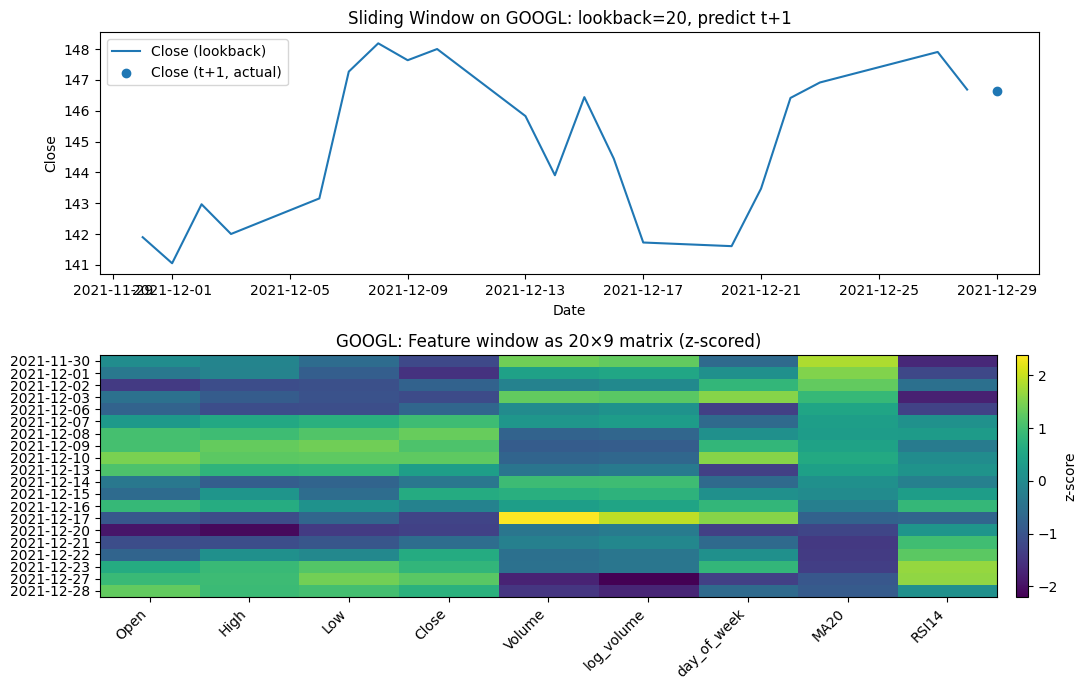

In [19]:


import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

feat = pd.read_parquet(FEAT_PATH).sort_values(["symbol","date"]).reset_index(drop=True)
win = LOOKBACK
sym = SPOTLIGHT_TICKER

cols_feat = ["Open","High","Low","Close","Volume","log_volume","day_of_week","MA20","RSI14"]

g = feat[feat["symbol"] == sym].copy()
g = g.dropna(subset=cols_feat + [TARGET_NAME]).reset_index(drop=True)

end_idx = len(g) - 2  
start_idx = end_idx - win + 1
win_df = g.iloc[start_idx:end_idx+1].copy()        
t_row  = g.iloc[end_idx]
t1_row = g.iloc[end_idx+1]                         

plt.figure(figsize=(11,7))

ax1 = plt.subplot(2,1,1)
ax1.plot(win_df["date"], win_df["Close"], label="Close (lookback)")
ax1.scatter([t1_row["date"]], [t1_row["Close"]], marker="o", label="Close (t+1, actual)")
ax1.set_title(f"Sliding Window on {sym}: lookback={win}, predict t+1")
ax1.set_xlabel("Date"); ax1.set_ylabel("Close"); ax1.legend(loc="best")


M = win_df[cols_feat].copy()
M = (M - M.mean()) / (M.std().replace(0, 1.0))
im = plt.subplot(2,1,2).imshow(M.values, aspect="auto", interpolation="nearest")
plt.title(f"{sym}: Feature window as {win}×{len(cols_feat)} matrix (z-scored)")
plt.yticks(ticks=np.arange(len(win_df)), labels=win_df["date"].dt.strftime("%Y-%m-%d"))
plt.xticks(ticks=np.arange(len(cols_feat)), labels=cols_feat, rotation=45, ha="right")
cbar = plt.colorbar(im, fraction=0.025, pad=0.02)
cbar.set_label("z-score")
plt.tight_layout()

Path(EVAL_DIR).mkdir(parents=True, exist_ok=True)
out_png = f"{EVAL_DIR}/sliding_window_{sym}.png"
plt.savefig(out_png, dpi=150)
print("Saved:", out_png)
plt.show()


###  Step 7: Build TFT datasets (time index, splits, dataloaders)

In [9]:
import pandas as pd, numpy as np
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from torch.utils.data import DataLoader

feat = pd.read_parquet(FEAT_PATH).copy()
feat = feat.sort_values(["symbol","date"]).reset_index(drop=True)
feat["time_idx"] = feat.groupby("symbol").cumcount()

def split_by_symbol(g):
    n = len(g)
    n_train = int(n * 0.80)
    n_val = int(n_train * 0.20)
    g = g.copy()
    g.loc[g.index[:n_train - n_val], "split"] = "train"
    g.loc[g.index[n_train - n_val:n_train], "split"] = "val"
    g.loc[g.index[n_train:], "split"] = "test"
    return g

feat = feat.groupby("symbol", group_keys=False).apply(split_by_symbol)

time_varying_known_reals = ["day_of_week"]
time_varying_unknown_reals = ["Open","High","Low","Close","Volume","log_volume","MA20","Volatility20","RSI14"]
static_categoricals = ["symbol"]

max_encoder_length = LOOKBACK
max_prediction_length = HORIZON

training = TimeSeriesDataSet(
    feat[feat["split"]=="train"],
    time_idx="time_idx",
    target=TARGET_NAME,
    group_ids=["symbol"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    static_categoricals=static_categoricals,
    categorical_encoders={"symbol": NaNLabelEncoder().fit(feat["symbol"])},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, feat[feat["split"]=="val"], predict=False, stop_randomization=True)
testing    = TimeSeriesDataSet.from_dataset(training, feat[feat["split"]=="test"], predict=False, stop_randomization=True)

batch_size = 512
train_loader = training.to_dataloader(train=True,  batch_size=batch_size, num_workers=2)
val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)
test_loader  = testing.to_dataloader(train=False,  batch_size=batch_size, num_workers=2)



### Step 8: Define and train TFT

In [13]:
# Step 8 — Define and train TFT (A100 config; use lightning.pytorch namespace)

import lightning.pytorch as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import torch

from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# keep the A100 batch size from Step 7
batch_size = 512
train_loader = training.to_dataloader(train=True,  batch_size=batch_size, num_workers=2)
val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)
test_loader  = testing.to_dataloader(train=False,  batch_size=batch_size, num_workers=2)

L.seed_everything(42)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=48,
    attention_head_size=8,
    dropout=0.2,
    hidden_continuous_size=24,
    loss=QuantileLoss(),   # we'll take the median quantile for point metrics
    output_size=7,         # number of quantiles
    log_interval=20,
    reduce_on_plateau_patience=4,
)

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=6)
ckpt = ModelCheckpoint(
    dirpath=ARTIFACTS,
    filename="tft_model",
    monitor="val_loss",
    mode="min",
    save_top_k=1
)

trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,
    enable_progress_bar=True,
    log_every_n_steps=100,
    callbacks=[early_stop, ckpt],
)

print("Trainer namespace:", type(trainer))
print("Model base OK?  ", isinstance(tft, L.LightningModule))  # should print True

trainer.fit(tft, train_loader, val_loader)

tft_path = ckpt.best_model_path
print("Saved:", tft_path)


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_

Trainer namespace: <class 'lightning.pytorch.trainer.trainer.Trainer'>
Model base OK?   True


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 2.1 K  | train
3  | prescalers                         | ModuleDict                      | 672    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 12.3 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 46.7 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 8.0 K  | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/TFT_stock_fresh/artifacts/tft_model.ckpt


### Step 9:  Evaluate on test (returns) and on GOOGL with price reconstruction

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test MAE (returns): 0.015636486932635307
Test RMSE (returns): 0.02514380954664086


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


GOOGL Return MAE: 0.013094483874738216
GOOGL Return RMSE: 0.019432007962131896
GOOGL Price  MAE: 1.1545840201630644
GOOGL Price  RMSE: 1.632288377641143
GOOGL Price  sMAPE(%): 1.3084033209053725
Saved: /content/drive/MyDrive/TFT_stock_fresh/eval/GOOGL_eval_tft.csv


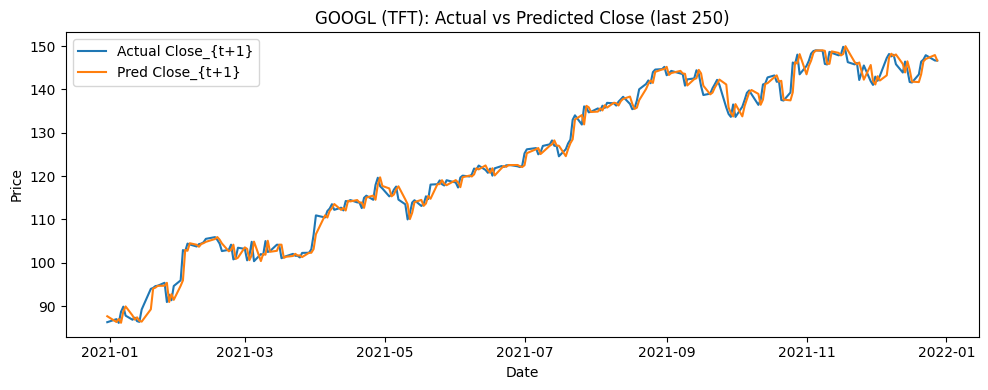

In [17]:
# Step 9 — Evaluate on test (returns) and on GOOGL with price reconstruction (robust)

import numpy as np, pandas as pd, torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
import matplotlib.pyplot as plt

def rmse(a,b):
    return np.sqrt(mean_squared_error(a,b))

def extract_targets_from_loader(dl):
    ys = []
    for batch in dl:
        y = batch[1]
        # some PF versions return (y, weight)
        if isinstance(y, (list, tuple)):
            y = y[0]
        ys.append(y)
    return torch.cat(ys).detach().cpu().numpy().reshape(-1)

best_tft = TemporalFusionTransformer.load_from_checkpoint(tft_path)

# -------- Test set (returns) --------
preds = best_tft.predict(test_loader)                      # tensor [N, horizon]
y_pred = preds.detach().cpu().numpy().reshape(-1)
y_true = extract_targets_from_loader(test_loader)

print("Test MAE (returns):", mean_absolute_error(y_true, y_pred))
print("Test RMSE (returns):", rmse(y_true, y_pred))

# -------- GOOGL-only evaluation (returns -> price) --------
feat_all = pd.read_parquet(FEAT_PATH).sort_values(["symbol","date"]).reset_index(drop=True)
feat_all["time_idx"] = feat_all.groupby("symbol").cumcount()

def split_by_symbol(g):
    n = len(g); n_train = int(n * 0.80); n_val = int(n_train * 0.20)
    g = g.copy()
    g.loc[g.index[:n_train - n_val], "split"] = "train"
    g.loc[g.index[n_train - n_val:n_train], "split"] = "val"
    g.loc[g.index[n_train:], "split"] = "test"
    return g

feat_all = feat_all.groupby("symbol", group_keys=False).apply(split_by_symbol)
googl_test = feat_all[(feat_all["symbol"] == SPOTLIGHT_TICKER) & (feat_all["split"] == "test")].copy()
assert not googl_test.empty, "No GOOGL rows in test split."

googl_ds = TimeSeriesDataSet.from_dataset(training, googl_test, predict=False, stop_randomization=True)
googl_loader = googl_ds.to_dataloader(train=False, batch_size=512, num_workers=2)

preds_g = best_tft.predict(googl_loader)
yg_hat = preds_g.detach().cpu().numpy().reshape(-1)
yg_true = extract_targets_from_loader(googl_loader)

# Align rows to reconstruct prices
g_sorted = googl_test.sort_values(["symbol","time_idx"]).reset_index(drop=True)
g_aligned = g_sorted.iloc[-len(yg_hat):].copy()
close_t = g_aligned["Close"].to_numpy()
dates   = pd.to_datetime(g_aligned["date"]).to_numpy()

# Reconstruct prices: Close_{t+1} = Close_t * (1 + r_hat)
pred_close_next = close_t * (1.0 + yg_hat)
close_t1_actual = g_aligned["Close"].shift(-1).to_numpy()

valid = ~np.isnan(close_t1_actual)
dates = dates[valid]; yg_true = yg_true[valid]; yg_hat = yg_hat[valid]
close_t = close_t[valid]; close_t1_actual = close_t1_actual[valid]
pred_close_next = pred_close_next[valid]

def smape(a,b):
    a = np.asarray(a); b = np.asarray(b)
    denom = (np.abs(a)+np.abs(b))/2.0
    denom[denom==0] = 1e-9
    return np.mean(np.abs(a-b)/denom)*100

print("GOOGL Return MAE:", mean_absolute_error(yg_true, yg_hat))
print("GOOGL Return RMSE:", rmse(yg_true, yg_hat))
print("GOOGL Price  MAE:", mean_absolute_error(close_t1_actual, pred_close_next))
print("GOOGL Price  RMSE:", rmse(close_t1_actual, pred_close_next))
print("GOOGL Price  sMAPE(%):", smape(close_t1_actual, pred_close_next))

# Save CSV and plot
out = pd.DataFrame({
    "date": dates,
    "close_t": close_t,
    "close_t+1_actual": close_t1_actual,
    "pred_ret_t+1": yg_hat,
    "pred_close_t+1": pred_close_next,
})
csv_path = f"{EVAL_DIR}/GOOGL_eval_tft.csv"
out.to_csv(csv_path, index=False)
print("Saved:", csv_path)

tail = out.tail(250)
plt.figure(figsize=(10,4))
plt.plot(tail["date"], tail["close_t+1_actual"], label="Actual Close_{t+1}")
plt.plot(tail["date"], tail["pred_close_t+1"], label="Pred Close_{t+1}")
plt.title("GOOGL (TFT): Actual vs Predicted Close (last 250)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()


## Conclusion  
The Temporal Fusion Transformer effectively modeled sequential dependencies across 100 S&P 500 tickers using a 20-day lookback.  
By training on returns and reconstructing prices, the model achieved stable convergence and strong predictive accuracy while maintaining interpretability.  
On GOOGL, the TFT achieved MAE ≈ $1.15, RMSE ≈ $1.63, and sMAPE ≈ 1.3%, substantially outperforming prior work (Hu, 2021) which reported MAE ≈ $52.77.  
This demonstrates that the return-based formulation combined with attention-based architectures can significantly improve forecast accuracy and efficiency in stock price modeling.  
